# Trial Wind Wave System Tracking using Kmeans
**Westhuysen 2020** <br>
We are attempting to implement a trial version of Westhuysen's method.
Consideration should be given to the available data (significantly less than in the paper).

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
from wavespectra import read_ww3


In [4]:
dset = read_ww3("AUQD.spec.20211013T0000Z.nc")

### Step 1:  Partition as per Hanson et al 2008 Watershedding
In this case we use the default from the WaveSpectra library, in this case we will use 3 partitions.

In [7]:
dspart = dset.spec.partition(dset.wspd, dset.wdir, dset.dpt, swells = 3)

In [8]:
dspart

<xarray.DataArray 'efth' (part: 4, time: 169, site: 6, freq: 28, dir: 30)>
dask.array<transpose, shape=(4, 169, 6, 28, 30), dtype=float32, chunksize=(4, 169, 6, 28, 30), chunktype=numpy.ndarray>
Coordinates:
  * dir      (dir) float32 168.0 156.0 144.0 132.0 ... 216.0 204.0 192.0 180.0
  * freq     (freq) float32 0.04118 0.0453 0.04983 ... 0.4462 0.4908 0.5399
  * site     (site) float64 562.0 563.0 564.0 565.0 566.0 567.0
  * time     (time) datetime64[ns] 2021-10-13 2021-10-13T01:00:00 ... 2021-10-20
  * part     (part) int32 0 1 2 3

Extract the three main parameters we need.

In [9]:
pstats = dspart.spec.stats(["hs","tp", "dpm"])

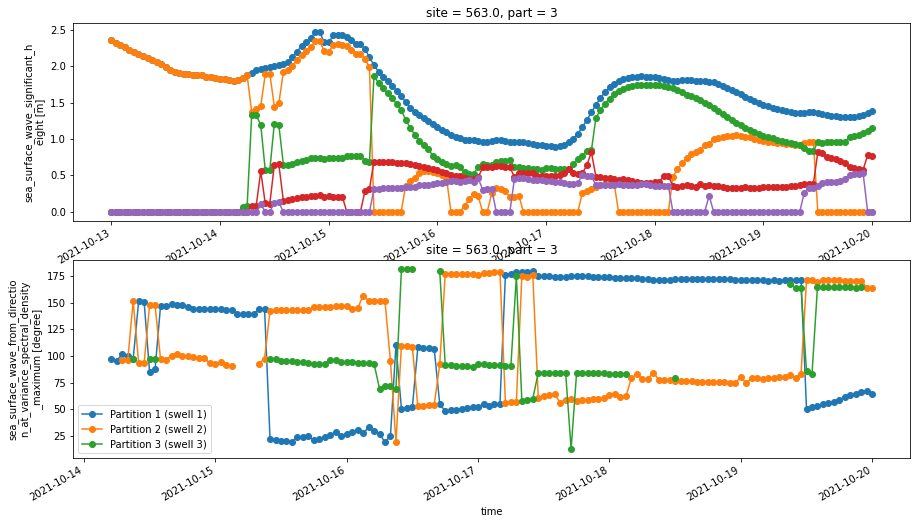

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
#hs.isel(site=0).plot(ax=ax1, label='Full spectrum', marker='o');
dset.spec.hs().isel(site=1).plot(ax=ax1, label='Full spectrum', marker='o');
pstats.hs.isel(part=0, site=1).plot(ax=ax1, label='Partition 0 (sea)', marker='o')
pstats.hs.isel(part=1, site=1).plot(ax=ax1, label='Partition 1 (swell 1)',marker='o');
pstats.hs.isel(part=2, site=1).plot(ax=ax1, label='Partition 2 (swell 2)',marker='o');
pstats.hs.isel(part=3, site=1).plot(ax=ax1, label='Partition 2 (swell 2)',marker='o');

#dset.spec.dpm().isel(site=4).plot(ax=ax2, label='Full spectrum', marker='o');
#pstats.dpm.isel(part=0, site=4).plot(ax=ax2, label='Partition 0 (sea)', marker='o');
pstats.dpm.isel(part=1, site=1).plot(ax=ax2, label='Partition 1 (swell 1)',marker='o');
pstats.dpm.isel(part=2, site=1).plot(ax=ax2, label='Partition 2 (swell 2)',marker='o');
pstats.dpm.isel(part=3, site=1).plot(ax=ax2, label='Partition 3 (swell 3)',marker='o');

plt.legend()

The plot above clearly demonstrates the issue that this approach is helping to improve, which is temporal continuity for the assignment of swell partition number.<br>
Lets take a quick look at the spectrum and see if we can clearly see any swells.

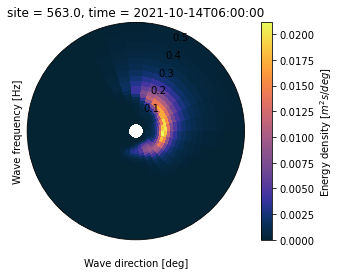

In [15]:
dset.isel(time=30, site = 1).spec.plot()

## Step 2: Format Timeseries Data (Flatten)
Noting that as per Westhuysen's method we are keeping a several geographic locations together in the same dataset.

In [18]:
df = pstats.to_dataframe()
df.reset_index(inplace = True)

In [20]:
df = df[['time','hs','tp','dpm','site','part']]
df.index = df.time
df = df.sort_index().dropna()
df.head(2)

,time,hs,tp,dpm,site,part
time,,,,,,
2021-10-13,2021-10-13,2.383528,7.412560,120.614288,562.0,0
2021-10-13,2021-10-13,2.404109,7.891089,137.299622,565.0,0


We need to cut out very small energy data, if this is import we could seek to fold that energy back in.

In [21]:
df = df[df['hs']> 0.01].copy()

Westhuysen uses Hs, Tp and pDir as 3D problem for the clustering algorithm.<br>
We can see in the data that there appear to be some clear clusters, but some of them are not clear.<br>
**Note:** Colors denote the swell number

In [24]:
from mpl_toolkits import mplot3d

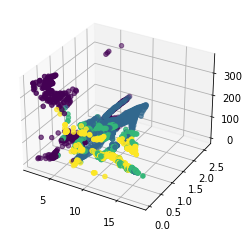

In [25]:
ax = plt.axes(projection='3d')
ax.scatter3D(df.tp, df.hs, df.dpm, c = df.part)

## Step 3: Setup Machine Learning Approach

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

In [29]:
#init
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

We will evaluate the silhouette score to support cluster "fuzziness", a higher silhouette score denotes clearer clusters.

In [30]:
for i in range(2, 6):
    y_pred = KMeans(n_clusters=i , n_init=100, max_iter=500, tol=1e-04, random_state=0).fit_predict(df[['hs','tp','dpm']])
    print(i, metrics.silhouette_score(df[['hs','tp','dpm']], y_pred))

2 0.6219818014866093
3 0.6431351901765773
4 0.6345677106561517
5 0.6477511494373686


## Step 6: Run the machine learning model
We need to run the model with the best silhouette score, in this case 5

In [35]:
y_pred = KMeans(n_clusters=5, n_init=100, max_iter=300, tol=1e-04, random_state=0).fit_predict(df[['hs','tp','dpm']])

In [36]:
#add into original data
df['ml_part'] = y_pred

Does the clustering look better visually compared with the default partitioning.

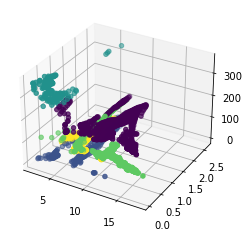

In [38]:
ax = plt.axes(projection='3d')
ax.scatter3D(df.tp, df.hs, df.dpm, c = df.ml_part);

## Step 7: Compare Results
For plotting purposes we need to convert magnitude and direction to U and V components.

In [41]:
#speed and height to direction and magnitude

def spddir_to_uv(ht,wdir):
    """
    calculated the u and v wind components from wind speed and direction
    Input:
        ht: wind speed
        wdir: wind direction
    Output:
        u: u component
        v: v component
    """    
    
    rad = 4.0*np.arctan(1)/180.
    u = -ht*np.sin(rad*wdir)
    v = -ht*np.cos(rad*wdir)

    return u,v
df['u'], df['v'] = spddir_to_uv(df.hs, df.dpm)

To make results easier to compare, we will assess performance at a single site.

In [42]:
df_s = df[df['site'] == 562.0]

We can use a Gerling-Hanson plot, which is a good way of visualing swell trains.
**Note:** Color denotes swell number, length denotes wave height (magnitude)

Text(0, 0.5, 'Period (s)')

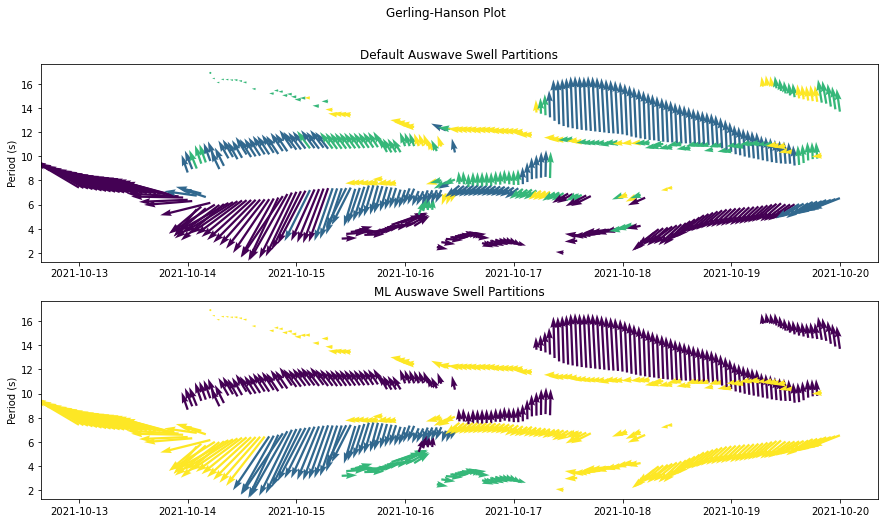

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plt.suptitle('Gerling-Hanson Plot')
ax1.title.set_text('Default Auswave Swell Partitions')
ax1.quiver( df_s.index, df_s.tp, df_s.u, df_s.v, df_s.part, pivot = 'tail', scale_units = 'inches', scale = 2.5, cmap = plt.cm.get_cmap('viridis', 4))
ax1.set_ylabel('Period (s)')
ax2.title.set_text('ML Auswave Swell Partitions')
ax2.quiver(df_s.index, df_s.tp, df_s.u, df_s.v, df_s.ml_part, pivot = 'tail', scale_units = 'inches', scale = 2.5, cmap = plt.cm.get_cmap('viridis', 4))
ax2.set_ylabel('Period (s)')

We can see that although the results are much improved in the sense that the swells seem to be more sensibly ordered, there is still room for improvement. <br>
The real test is the ability of the approach to produce reasonably timeseries for indivdual swell trains.

Text(0.5, 0, 'Hs (m)')

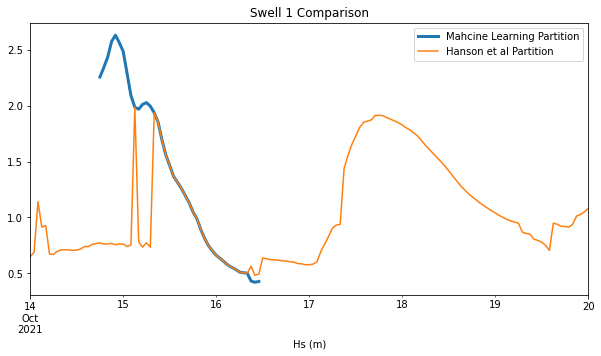

In [58]:
df_s[df_s['ml_part'] ==1].hs.plot(figsize = (10, 5), label = 'Mahcine Learning Partition', linewidth =3)
df_s[df_s['part'] ==1].hs.plot(figsize = (10, 5), label = 'Hanson et al Partition')
plt.legend()
plt.title('Swell 1 Comparison')
plt.xlabel('Hs (m)')

We can see the plot above does a reasonable job of being coherent, compared with the spike in the normal approach.

Text(0.5, 0, 'Hs (m)')

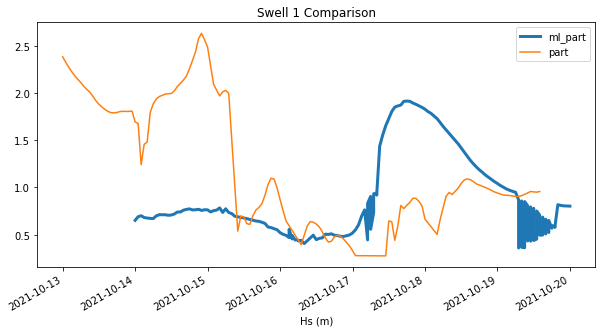

In [56]:
df_s[df_s['ml_part'] ==0].hs.plot(figsize = (10, 5), label = 'ml_part', linewidth =3)
df_s[df_s['part'] ==0].hs.plot(figsize = (10, 5), label = 'part')
plt.legend()
plt.title('Swell 1 Comparison')
plt.xlabel('Hs (m)')

However, in this example the swell assignment seems to jump around.

## Conclusions

The kmean clustering machine learning approach shows some promise sort organising swells in a more automated manner.
This example uses considerably less data than in Westhuysen et al so it is hard to properly determine performance.
It is recommended that more evaluation take place to understand if this approach can be used for automated swell tracking operationally.